# Домашнее задание к занятию «Классификация: Логистическая регрессия и SVM»

In [213]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

* В домашнем задании нужно решить задачу классификации физических лиц по уровню дохода. Данные для обучения модели хранятся в файле adult.csv
* Целевая переменная – уровень дохода income, который принимает два значения <=50K и >50K, поэтому классификация бинарная. Остальные признаки описывают персональную информацию – возраст, образование, семейное положение и т. д. 
* Задачу классификации нужно решить при помощи модели логистической регрессии и модели опорных векторов.

In [214]:
data = pd.read_csv('adult.csv', na_values='?')
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


Проведите первичный анализ:
* Проверьте данные на пропуски. Удалите в случае обнаружения. Предложите альтернативный способ работы с пропусками
* Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака)
* Преобразуйте категориальные признаки

In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [216]:
# Удаляем пропуски по столбцам - workclass, occupation, native-country 
# На основании имеющихся данных по заполненным столбцам сложно заполнить корректно категориальные данные
data = data.dropna()

In [217]:
# Проверим дубликаты
duplicates = data.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

47

In [218]:
# Удалим дубликаты из данных для анализа
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45175 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45175 non-null  int64 
 1   workclass        45175 non-null  object
 2   fnlwgt           45175 non-null  int64 
 3   education        45175 non-null  object
 4   educational-num  45175 non-null  int64 
 5   marital-status   45175 non-null  object
 6   occupation       45175 non-null  object
 7   relationship     45175 non-null  object
 8   race             45175 non-null  object
 9   gender           45175 non-null  object
 10  capital-gain     45175 non-null  int64 
 11  capital-loss     45175 non-null  int64 
 12  hours-per-week   45175 non-null  int64 
 13  native-country   45175 non-null  object
 14  income           45175 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


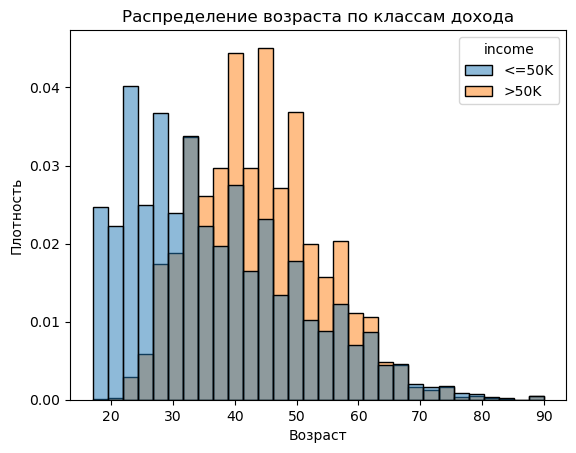

In [219]:
# Предположим зависимость показателей возраст - доход, проверим это визуально
sns.histplot(data=data, x='age', hue='income', bins=30, stat='density', common_norm=False)
plt.title('Распределение возраста по классам дохода')
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.show()

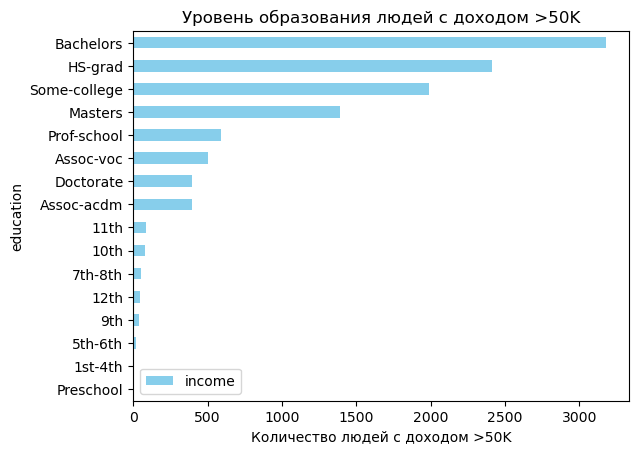

In [220]:
# Определим взаимосвязь уровня образования с показателем дохода (рассмотрим выборку людей с доходом свыше 50к)
data_group = data[(data['income'] == '>50K')]
data_group = data_group[['education', 'income']].groupby('education').count().sort_values(by='income')
data_group.plot(kind='barh', color='skyblue')
plt.xlabel('Количество людей с доходом >50K')
plt.title('Уровень образования людей с доходом >50K')
plt.show()

In [221]:
# Преобразуем категориальные признаки
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print('Категориальные признаки:', categorical_cols)

Категориальные признаки: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']


In [222]:
select_сolumns = data[['age', 'education', 'income']]
select_сolumns

,age,education,income
0,25,11th,<=50K
1,38,HS-grad,<=50K
2,28,Assoc-acdm,>50K
3,44,Some-college,>50K
5,34,10th,<=50K
...,...,...,...
48837,27,Assoc-acdm,<=50K
48838,40,HS-grad,>50K
48839,58,HS-grad,<=50K
48840,22,HS-grad,<=50K


In [223]:
X = pd.get_dummies(select_сolumns, columns=['education'])
del X['income']
X.head()

,age,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college
0,25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,28,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,34,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [224]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [225]:
le.fit(data['income'])

LabelEncoder()

In [226]:
le.classes_

array(['<=50K', '>50K'], dtype=object)

In [227]:
y = pd.Series(data=le.transform(data['income']))
y.head()

0    0
1    0
2    1
3    1
4    0
dtype: int64

Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [228]:
from sklearn.model_selection import train_test_split

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучение модели методом Логистической регрессии

In [230]:
from sklearn.linear_model import LogisticRegression

In [231]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

Для тестового множества предскажите уровень дохода 

In [232]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [233]:
model.predict_proba(X_test)

array([[0.90617218, 0.09382782],
       [0.85956154, 0.14043846],
       [0.90950257, 0.09049743],
       ...,
       [0.52207195, 0.47792805],
       [0.64110028, 0.35889972],
       [0.85519856, 0.14480144]])

Посчитайте точность предсказания моделей. Для этого используйте встроенную функцию score.

In [234]:
from sklearn.metrics import accuracy_score

In [235]:
model.score(X_train, y_train) 

0.7780298837852795

In [236]:
log_acc = model.score(X_test,y_test)
log_acc

0.7754288876591034

Обучение модели методом опорных векторов на обучающем множестве.

In [237]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [238]:
# SVM с RBF ядром (по умолчанию)
svm_rbf = SVC()
svm_rbf.fit(X_train, y_train)

SVC()

In [239]:
svm_rbf.score(X_train, y_train) 

0.7507194244604316

In [240]:
svm_rbf_acc = svm_rbf.score(X_test,y_test)
svm_rbf_acc

0.7572772551189817

In [241]:
# SVM с RBF ядром и StandardScaler - масштабирование признаков
svm_rbf_scaler = make_pipeline(StandardScaler(), SVC()) 
svm_rbf_scaler.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [242]:
svm_rbf_scaler.score(X_train, y_train) 

0.787382401770891

In [243]:
svm_rbf_scaler_acc = svm_rbf_scaler.score(X_test,y_test)
svm_rbf_scaler_acc

0.7822910902047593

In [244]:
# SVM с линейным ядром (linear)
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [245]:
svm_linear.score(X_train, y_train) 

0.7723021582733813

In [246]:
svm_linear_acc = svm_linear.score(X_test,y_test)
svm_linear_acc

0.7734366353071389

Сформулируйте выводы по проделанной работе:
a) кратко опишите какие преобразования были сделаны с данными.
b) cравните точность двух моделей.
c) напишите свое мнение, в полной ли мере модели справились с поставленной задачей.
* Что по вашему мнению нужно сделать, чтобы улучшить результат?

In [258]:
print(f'Результаты: \nLogistic Regression: {log_acc:.3f},\n'
    f'SVM RBF: {svm_rbf_acc:.3f}, \n'
    f'SVM RBF StandardScaler: {svm_rbf_scaler_acc:.3f}, \n'
    f'SVM Linear: {svm_linear_acc:.3f}')

Результаты: 
Logistic Regression: 0.775,
SVM RBF: 0.757, 
SVM RBF StandardScaler: 0.782, 
SVM Linear: 0.773


* В ДЗ проанализирован датасет adult.csv
* Мы предсказываем целевую переменную income на основании двух признаков: age, education.
* Все рассмотренные модели показали хорошее качество классификации.
* Масштабирование признаков StandardScaler значимо влияет на работу SVM
* Наилучший результат на тестовой выборке получен при применении SVM RBF с использованием StandardScaler